<a href="https://colab.research.google.com/github/irfanbykara/Machine-Learning-Notebooks/blob/main/Unet_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the implementation of the paper U-Net: Convolutional Networks for Biomedical Image Segmentation in Pytorch. I will be keeping it as simple as possible for readability.


In [ ]:
residual_shape = {128:392,256:200,512:104,1024:56}

In [ ]:
import torch
from torch import nn

class BasicConv(nn.Module):
  def __init__(self,in_channel,out_channel):
    super().__init__()

    self.out_channel = out_channel
    self.conv = nn.Conv2d(in_channel,out_channel,stride=1,padding=0,kernel_size=3)

    self.conv2 = nn.Conv2d(out_channel,out_channel,stride=1,padding=0,kernel_size=3)

    self.relu = nn.ReLU()

  def forward(self,x,calculate_residual=False):
    residual = None

    x = self.conv(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)

    if calculate_residual != True:
      return x,residual

    target_size = residual_shape[int(self.out_channel*2)]
    target_size_tuple = (target_size,target_size)
    # Calculate the cropping dimensions
    crop_height = x.size(2) - target_size_tuple[0]
    crop_width = x.size(3) - target_size_tuple[1]

    # Crop the tensor
    residual = x[:, :, crop_height//2:-(crop_height - crop_height//2), crop_width//2:-(crop_width - crop_width//2)]




    return x,residual

In [ ]:
x = torch.rand(1,3, 572, 572)  # Adjust the number of channels to match the input
basic_conv = BasicConv(x.size(1), 64)  # Use x.size(1) to get the number of input channels
output, residual = basic_conv(x,calculate_residual=True)
output.shape, residual.shape

(torch.Size([1, 64, 568, 568]), torch.Size([1, 64, 392, 392]))

In [ ]:
class Pooling(nn.Module):
  def __init__(self):
    super().__init__()

    self.pool = nn.MaxPool2d(stride=2,kernel_size=2)

  def forward(self,x):
    x = self.pool(x)
    return x

In [ ]:
pooling = Pooling()
output = pooling(output)
output.shape


torch.Size([1, 64, 284, 284])

In [ ]:
class UpConv(nn.Module):
  def __init__(self,in_channel,out_channel):
    super().__init__()

    self.conv = nn.ConvTranspose2d(in_channel,out_channel,stride=2,padding=0,kernel_size=2)

  def forward(self,x,downsample=False):
    x = self.conv(x)
    return x

In [ ]:
upconv = UpConv(output.size(1),int((output.size(1)/2)))

output = upconv(output)

In [ ]:
# channels = [64,128,256,512]

class Encoder(nn.Module):
  def __init__(self,in_channel,channels):
    super().__init__()

    self.conv_blocks = []
    for i in range(len(channels)):
      conv = BasicConv(in_channel,channels[i])
      in_channel = channels[i]
      self.conv_blocks.append(conv)

    self.pool = Pooling()

  def forward(self,x):
    residuals = []
    for conv in self.conv_blocks:
      x,residual = conv(x,calculate_residual=True)
      residuals.append(residual)
      x = self.pool(x)

    return x, residuals

In [ ]:
trial_var = torch.rand(1,3,572,572)

trial_var.shape[1]

3

In [ ]:
encoder = Encoder(trial_var.shape[1],channels)
output,residuals = encoder(trial_var)
output.shape

torch.Size([1, 512, 32, 32])

In [ ]:
class Bottleneck(nn.Module):
  def __init__(self,in_channel,out_channel):
    super().__init__()
    self.conv = BasicConv(in_channel,out_channel)

  def forward(self,x):
    output, _ = self.conv(x,calculate_residual=False)
    return output


In [ ]:
bottleneck = Bottleneck(output.shape[1],output.shape[1]*2)

output = bottleneck(output)
output.shape

torch.Size([1, 1024, 28, 28])

In [ ]:
for res in residuals:
  print(res.shape)

torch.Size([1, 64, 392, 392])
torch.Size([1, 128, 200, 200])
torch.Size([1, 256, 104, 104])
torch.Size([1, 512, 56, 56])


In [ ]:
channels = [1024,512,256,128]

class Decoder(nn.Module):
  def __init__(self,channels):
    super().__init__()

    self.up_conv_blocks = []
    self.basic_conv_blocks = []

    for i in range(len(channels)):
      up_conv = UpConv(channels[i],int(channels[i]/2))
      self.up_conv_blocks.append(up_conv)
      basic_conv = BasicConv(channels[i],int(channels[i]/2))
      self.basic_conv_blocks.append(basic_conv)


  def forward(self,x,residuals):

    residuals.reverse()
    for i in range(len(self.up_conv_blocks)):
      x = self.up_conv_blocks[i](x)

      x = torch.cat((x, residuals[i]), dim=1)
      x, _ = self.basic_conv_blocks[i](x)

    return x

In [ ]:
decoder = Decoder(channels)

output = decoder(output,residuals)

In [ ]:
output.shape


torch.Size([1, 64, 388, 388])

In [ ]:
# Define a function to perform the division
def divide_by_divisor(number, divisor):
    return int(number / divisor)


In [ ]:
class UNet(nn.Module):
  def __init__(self,in_channels):
    super().__init__()
    self.in_channels = in_channels

    architecture_shape ={128:392,256:200,512:104,1024:56}
    channels_for_encoder = architecture_shape.keys()
    # Use map() to divide all elements in the list by the divisor
    channels_for_encoder = list(map(lambda x: divide_by_divisor(x, 2), channels_for_encoder))

    print(channels_for_encoder)

    self.encoder = Encoder(self.in_channels,channels_for_encoder)
    print(channels_for_encoder)

    self.bottleneck = Bottleneck(512,1024)
    print(channels_for_encoder)


    channels_for_decoder = list(architecture_shape.keys())
    channels_for_decoder.reverse()
    print(channels_for_decoder)


    self.decoder = Decoder(channels_for_decoder)

    self.final = nn.Conv2d(in_channels=64,out_channels=1,stride=1,kernel_size=1)

  def forward(self,x):

    x,residuals = self.encoder(x)
    x = self.bottleneck(x)
    x = decoder(x,residuals)
    x = self.final(x)
    return x






In [ ]:
unet = UNet(3)
x = torch.rand(1,3, 572, 572)  # Adjust the number of channels to match the input
output = unet(x)

[64, 128, 256, 512]
[64, 128, 256, 512]
[64, 128, 256, 512]
[1024, 512, 256, 128]


In [ ]:
output.shape

torch.Size([1, 2, 388, 388])

In [ ]:
output_squuezed = output.squeeze(0)
output_squuezed=output_squuezed.permute(1,2,0)

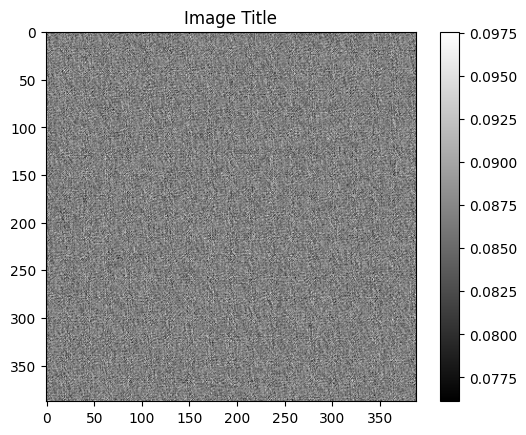

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(output_squuezed.detach().numpy(), cmap='gray')  # 'gray' for grayscale, use other colormaps for color images
plt.title("Image Title")
plt.colorbar()  # Add a colorbar (optional)
plt.show()


